In [1]:
import matplotlib.pyplot as plt

import torch

from config import *

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from utils import test_augmentation

from engine import get_model

import numpy as np

In [2]:
model = get_model()

valid_data = ImageFolder(VAL_DATA, transform=test_augmentation)

valid_loader = DataLoader(
	valid_data, batch_size=BATCH_SIZE, num_workers=12
)

In [3]:
model.eval()

predictions = []
answers = []

for x, y in valid_loader:
	with torch.no_grad():
		pred = model(x.cuda()).cpu()
	predictions.append(pred)
	answers.append(y)

In [4]:
pred_per_class = {}

for pred, ans, in zip(predictions, answers):
	for x, y in zip(pred, ans):
		if y.item() not in pred_per_class:
			pred_per_class[y.item()] = []
		pred_per_class[y.item()].append(x)

In [5]:
from collections import Counter

error_by_class = {}
most_popular_classes = Counter()

top_k = [1, 3, 5]

for y, pred in pred_per_class.items():
	error_by_class[y] = Counter()
	for x in pred:
		most_popular_classes[x.argmax().item()] += 1
		for i in top_k:
			if y in torch.topk(x, i).indices:
				error_by_class[y][i] += 1

	for i in top_k:
		if i in error_by_class[y].keys():
			error_by_class[y][i] = round(error_by_class[y][i] / len(pred_per_class[y]), 2)
error_by_class

{0: Counter({5: 0.96}),
 1: Counter({3: 1.0, 5: 1.0}),
 2: Counter(),
 3: Counter({1: 1.0, 3: 1.0, 5: 1.0}),
 4: Counter({3: 1.0, 5: 1.0}),
 5: Counter({5: 0.08}),
 6: Counter(),
 7: Counter(),
 8: Counter({5: 1.0}),
 9: Counter()}

### Top k-predict

<Figure size 1440x3600 with 0 Axes>

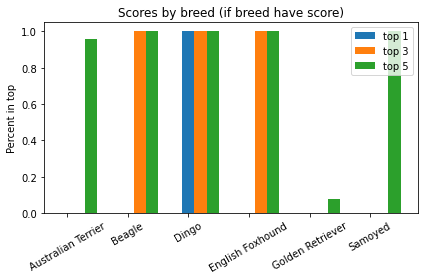

In [6]:
plt.figure(figsize=(20, 50))

indices = [i for i in range(10) if error_by_class[i].keys()]
labels = [model.classes[i].replace('_', ' ').title() for i in indices]

x = np.arange(len(labels))
width = 0.2

top_1 = [error_by_class[i][1] for i in indices]
top_3 = [error_by_class[i][3] for i in indices]
top_5 = [error_by_class[i][5] for i in indices]

fig, ax = plt.subplots()
rects1 = ax.bar(x, top_1, width, label='top 1')
rects2 = ax.bar(x + width, top_3, width, label='top 3')
rects3 = ax.bar(x + 2 * width, top_5, width, label='top 5')

ax.set_ylabel('Percent in top')
ax.set_title('Scores by breed (if breed have score)')
ax.set_xticks(x, labels)
plt.xticks(rotation=30)
ax.legend()

fig.tight_layout()

plt.show()

In [7]:
predictions = torch.cat(predictions, 0)
answers = torch.cat(answers, 0)
n_ans = answers.reshape(answers.shape[0], 1)

In [8]:
for i in top_k:
	t_ans = torch.cat([n_ans for _ in range(i)], 1)
	sum_ans = torch.sum(torch.eq(n_ans, torch.topk(predictions, i).indices))
	print(f"top {i} - {round((sum_ans / len(answers)).item(), 3)}")

top 1 - 0.104
top 3 - 0.312
top 5 - 0.52


### Most Popular classes

In [ ]:
labels = [model.classes[i].replace('_', ' ').title() for i in most_popular_classes.keys()]

plt.pie(most_popular_classes.values(), labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()